## Zero-shot prediction of *BRCA1* variant effects with Evo 2

The human *BRCA1* gene encodes for a protein that repairs damaged DNA ([Moynahan et al., 1999](https://www.cell.com/molecular-cell/fulltext/S1097-2765%2800%2980202-6)). Certain variants of this gene have been associated with an increased risk of breast and ovarian cancers ([Miki et al., 1994](https://www.science.org/doi/10.1126/science.7545954?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed)). Using Evo 2, we can predict whether a particular single nucleotide variant (SNV) of the *BRCA1* gene is likely to be harmful to the protein's function, and thus potentially increase the risk of cancer for the patient with the genetic variant.

We start by loading a dataset from [Findlay et al. (2018)](https://www.nature.com/articles/s41586-018-0461-z), which contains experimentally measured function scores of 3,893 *BRCA1* SNVs. These function scores reflect the extent by which the genetic variant has disrupted the protein's function, with lower scores indicating greater disruption. In this dataset, the SNVs are classified into three categories based on their function scores: `LOF` (loss-of-function), `INT` (intermediate), and `FUNC` (functional). We start by reading in this dataset.

### Setup imports

In [ ]:
from Bio import SeqIO, Seq
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score
import io
import base64

import numpy as np
import requests
from tqdm import tqdm

# Set root path
os.chdir('../..')

### Load API and define functions to use it

In [2]:
NVIDIA_API_KEY = os.getenv("NVCF_RUN_KEY") or os.getenv("NVIDIA_API_KEY")
BASE_URL = "https://health.api.nvidia.com/v1/biology"

if NVIDIA_API_KEY is None:
    raise RuntimeError(
        "Missing NVIDIA API key. Set env var NVCF_RUN_KEY or NVIDIA_API_KEY."
    )

HEADERS = {
    "Authorization": f"Bearer {NVIDIA_API_KEY}",
    "Content-Type": "application/json",
}

def evo2_generate(
    sequence,
    num_tokens=100,
    temperature=0.7,
    top_k=1,
    top_p=0.0,
    seed=None,
    enable_sampled_probs=False,
    enable_logits=False,
    model="evo2-7b"
):
    """Call Evo2 / generate to extend a DNA seed."""
    payload = {
        "sequence": sequence,
        "num_tokens": int(num_tokens),
        "temperature": float(temperature),
        "top_k": int(top_k),
        "top_p": float(top_p),
        "enable_sampled_probs": bool(enable_sampled_probs),
        "enable_elapsed_ms_per_token": False,
        "enable_logits": bool(enable_logits),
    }
    if seed is not None:
        payload["random_seed"] = int(seed)

    url = f"{BASE_URL}/arc/{model}/generate"
    r = requests.post(url, headers=HEADERS, json=payload, timeout=120)
    r.raise_for_status()
    return r.json()

def evo2_forward(sequence, output_layers=None, model="evo2-7b"):
    """
    Call Evo2 /forward to get layer outputs (embeddings/logits) as base64 NPZ. (numpy zip format)
    Returns a dict-like {layer_name: np.ndarray}.
    """
    if output_layers is None:
        # 'unembed' is typically the final pre-softmax logits
        output_layers = ["unembed"]

    payload = {
        "sequence": sequence,
        "output_layers": output_layers
    }

    url = f"{BASE_URL}/arc/{model}/forward"
    r = requests.post(url, headers=HEADERS, json=payload, timeout=300)
    r.raise_for_status()
    # parse the output
    blob = r.json()["data"]  # base64-encoded NPZ
    npz = np.load(io.BytesIO(base64.b64decode(blob)))
    return {k: npz[k] for k in npz.files}


# Test the generate API
# seed_seq = "TTCCGGTTCC"
# out = evo2_generate(seed_seq, model="evo2-40b", num_tokens=20, seed=123, enable_sampled_probs=True, enable_logits=True)
# print("Generated sequence:", out["sequence"])

# Test the forward API
# out = evo2_forward(seed_seq)
# # Inspect each layer’s embedding shape
# for name, arr in out.items():
#     print(f"{name} shape = {arr.shape}")
#     print(f"First few values: {arr.flatten()[:5]}\n")

### Load data and preprocess

In [3]:
brca1_df = pd.read_excel(
    os.path.join('notebooks', 'brca1', '41586_2018_461_MOESM3_ESM.xlsx'),
    header=2,
)
brca1_df = brca1_df[[
    'chromosome', 'position (hg19)', 'reference', 'alt', 'function.score.mean', 'func.class',
]]

brca1_df.head(10)

,chromosome,position (hg19),reference,alt,function.score.mean,func.class
0,17,41276135,T,G,-0.372611,FUNC
1,17,41276135,T,C,-0.045313,FUNC
2,17,41276135,T,A,-0.108254,FUNC
3,17,41276134,T,G,-0.277963,FUNC
4,17,41276134,T,C,-0.388414,FUNC
5,17,41276134,T,A,-0.280973,FUNC
6,17,41276133,C,T,-0.973683,INT
7,17,41276133,C,G,-0.373489,FUNC
8,17,41276133,C,A,0.006314,FUNC
9,17,41276132,A,T,-0.207552,FUNC


We then group the `FUNC` and `INT` classes of SNVs together into a single category (`FUNC/INT`).

In [4]:
# Rename columns
brca1_df.rename(columns={
    'chromosome': 'chrom',
    'position (hg19)': 'pos',
    'reference': 'ref',
    'alt': 'alt',
    'function.score.mean': 'score',
    'func.class': 'class',
}, inplace=True)

# Convert to two-class system
brca1_df['class'] = brca1_df['class'].replace(['FUNC', 'INT'], 'FUNC/INT')

brca1_df.head(10)

,chrom,pos,ref,alt,score,class
0,17,41276135,T,G,-0.372611,FUNC/INT
1,17,41276135,T,C,-0.045313,FUNC/INT
2,17,41276135,T,A,-0.108254,FUNC/INT
3,17,41276134,T,G,-0.277963,FUNC/INT
4,17,41276134,T,C,-0.388414,FUNC/INT
5,17,41276134,T,A,-0.280973,FUNC/INT
6,17,41276133,C,T,-0.973683,FUNC/INT
7,17,41276133,C,G,-0.373489,FUNC/INT
8,17,41276133,C,A,0.006314,FUNC/INT
9,17,41276132,A,T,-0.207552,FUNC/INT


Check the number of each type of mutation (Loss of function or not).

In [5]:
# print the class distribution
brca1_df['class'].value_counts()

class
FUNC/INT    3070
LOF          823
Name: count, dtype: int64

We build a function to parse the reference and variant sequences of a 8,192-bp window around the genomic position of each SNV, using the reference sequence of human chromosome 17 where *BRCA1* is located.

In [6]:
WINDOW_SIZE = 8192

# Read the reference genome sequence of chromosome 17
with gzip.open(os.path.join('notebooks', 'brca1', 'GRCh37.p13_chr17.fna.gz'), "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq_chr17 = str(record.seq)
        print(f'Chromosome 17 is loaded with length: {len(seq_chr17)} bp')
        break

# generate a reference sequence and a variant sequence given a position, reference nucleotide, and alternative nucleotide
def parse_sequences(seq, pos, ref, alt):
    """
    Parse reference and variant sequences from the reference genome sequence.
    """
    # the positions in the input file are 1-indexed, correct this by subtracting 1
    p = pos - 1 # Convert to 0-indexed position

    # Calculate the half window size to center the sequence around the SNV
    half_window = WINDOW_SIZE // 2

    # the first position of the reference sequence should be at least 0
    # the last position of the reference sequence should be at most the length of the chromosome sequence
    ref_seq_start = max(0, p - half_window)
    ref_seq_end = min(len(seq), p + half_window)

    # slice out the reference sequence
    ref_seq = seq_chr17[ref_seq_start:ref_seq_end]

    # Calculate the position of the SNV within the reference sequence
    snv_pos_in_ref = min(WINDOW_SIZE//2, p)
    var_seq = ref_seq[:snv_pos_in_ref] + alt + ref_seq[snv_pos_in_ref+1:]

    # Sanity checks
    assert len(var_seq) == len(ref_seq)
    assert ref_seq[snv_pos_in_ref] == ref
    assert var_seq[snv_pos_in_ref] == alt

    return ref_seq, var_seq

# Parse sequences for the first variant
row = brca1_df.iloc[0]
ref_seq, var_seq = parse_sequences(seq_chr17, row['pos'], row['ref'], row['alt'])

print(row)
print('--')
print(f'Reference, SNV 0: ...{ref_seq[4082:4112]}...')
print(f'Variant, SNV 0:   ...{var_seq[4082:4112]}...')

Chromosome 17 is loaded with length: 81195210 bp
chrom          17
pos      41276135
ref             T
alt             G
score   -0.372611
class    FUNC/INT
Name: 0, dtype: object
--
Reference, SNV 0: ...TGTTCCAATGAACTTTAACACATTAGAAAA...
Variant, SNV 0:   ...TGTTCCAATGAACTGTAACACATTAGAAAA...


In [7]:
# Build mappings of unique reference sequences
ref_seqs = []
ref_seq_to_index = {}

# Parse sequences and store indexes
ref_seq_indexes = []
var_seqs = []

# loop over the rows in the dataframe
for _, row in brca1_df.iterrows():

    # get the reference and variant sequences
    ref_seq, var_seq = parse_sequences(seq_chr17, row['pos'], row['ref'], row['alt'])

    # Get or create index for reference sequence (to avoid duplicates)
    if ref_seq not in ref_seq_to_index:
        ref_seq_to_index[ref_seq] = len(ref_seqs)
        ref_seqs.append(ref_seq)
    
    ref_seq_indexes.append(ref_seq_to_index[ref_seq])
    var_seqs.append(var_seq)

ref_seq_indexes = np.array(ref_seq_indexes)

In [8]:
# There are less unique reference sequences than total sequences because some variants share the same reference sequence
# AKA when the variants are at the same position
print(f'Number of unique reference sequences: {len(ref_seqs)}')
print(f'Number of variant sequences: {len(var_seqs)}')

Number of unique reference sequences: 1326
Number of variant sequences: 3893


### Remake the model.score_sequences function for the API version

In [9]:
# -----------------------------
# Math utilities (API-agnostic)
# -----------------------------

# logits = raw model outputs
# normalized to log-probabilities via log-softmax
def logits_to_log_softmax(logits):
    """Numerically stable log-softmax across last axis (vocab)."""
    # logits: (..., V)
    max_logits = np.max(logits, axis=-1, keepdims=True)
    stabilized = logits - max_logits
    logsumexp = np.log(np.sum(np.exp(stabilized), axis=-1, keepdims=True))
    return stabilized - logsumexp


# creates an array of per-position entropies from logits
def per_position_entropy_from_logits(logits):
    """
    Entropy H(p) = -sum_i p_i log p_i for each position.
    logits: (L, V) or (B, L, V). We handle both.
    Returns: (L,) or (B, L,)
    """
    log_probs = logits_to_log_softmax(logits)
    probs = np.exp(log_probs)
    ent = -np.sum(probs * log_probs, axis=-1)
    return ent


def gather_logprobs_for_sequence_tokens(log_probs, seq):
    """
    Given per-position log_probs (L, V) for next-token distribution at each position
    and the ground-truth ASCII sequence string, gather the log-prob assigned to the
    actually observed next token at each position (shifted by 1, autoregressive).
    """
    token_ids = np.fromiter((ord(c) for c in seq), dtype=np.int64)
    L, V = log_probs.shape

    if len(token_ids) != L:
        raise ValueError(f"Sequence length {len(token_ids)} != logits length {L}")

    target_ids = token_ids[1:]  # next-token targets
    next_token_logprobs = log_probs[:-1, :][np.arange(L - 1), target_ids]
    return next_token_logprobs


# -----------------------------
# API-based metrics
# -----------------------------
def forward_logits(sequence, model="evo2-7b"):
    """
    Fetch final-layer logits for a single sequence.
    Returns (L, V) numpy array.
    """
    out = evo2_forward(sequence, output_layers=["unembed"], model=model)

    logits = out["unembed.output"]
    if logits.ndim == 3 and logits.shape[0] == 1:
        logits = logits[0]  # squeeze batch if present (1, L, V) -> (L, V)
    if logits.ndim != 2:
        raise RuntimeError(f"Expected logits shape (L, V), got {logits.shape}")
    return logits


def positional_entropies_api(seqs, model="evo2-7b", show_progress=True):
    """
    API version of positional_entropies.
    Returns a list of arrays, one per sequence, of per-position entropy.
    """
    ent_list = []
    iterator = tqdm(seqs, desc="entropy", leave=False) if show_progress else seqs
    for s in iterator:
        logits = forward_logits(s, model=model)  # (L, V)
        ent = per_position_entropy_from_logits(logits)  # (L,)
        ent_list.append(ent)
    return ent_list


def score_perplexity_along_sequence_api(seq, model="evo2-7b",
                                        reverse_complement=True,
                                        return_entropy=False):
    """
    API version of score_perplexity_along_sequence.
    Computes per-position entropy (or exp(entropy) as perplexity).
    If reverse_complement=True, averages forward strand with RC (flipped back to forward orientation).
    """
    # forward
    ent_f = positional_entropies_api([seq], model=model, show_progress=False)[0]

    if reverse_complement:
        seq_rc = str(Seq(seq).reverse_complement())
        ent_rc = positional_entropies_api([seq_rc], model=model, show_progress=False)[0]
        ent_rc = ent_rc[::-1]  # flip back into forward orientation
        ent_avg = 0.5 * (ent_f + ent_rc)
    else:
        ent_avg = ent_f

    if return_entropy:
        return ent_avg
    else:
        return np.exp(ent_avg)  # per-position perplexity


# -----------------------------
# Sequence scoring (PLL) via API
# -----------------------------
def _sequence_loglik_api(seq, model, reduce_method="mean"):
    """
    Compute a single sequence's reduced log-likelihood by:
    - fetching logits (L, V),
    - log-softmax,
    - gathering log-prob for the actually observed next token at each position,
    - reducing by mean (default) or sum (PLL).
    """
    logits = forward_logits(seq, model=model)  # (L, V)
    log_probs = logits_to_log_softmax(logits)  # (L, V)
    next_token_ll = gather_logprobs_for_sequence_tokens(log_probs, seq)  # (L-1,)

    if reduce_method == "sum":
        return float(np.sum(next_token_ll))
    elif reduce_method == "mean":
        return float(np.mean(next_token_ll))
    else:
        raise ValueError(f"Invalid reduce_method '{reduce_method}'. Use 'mean' or 'sum'.")


def score_sequences_api(seqs, model="evo2-7b", reduce_method="mean", show_progress=True):
    """
    API version of score_sequences.
    """
    scores = []
    iterator = tqdm(seqs, desc="PLL", leave=False) if show_progress else seqs
    for s in iterator:
        scores.append(
            _sequence_loglik_api(
                s,
                model=model,
                reduce_method=reduce_method,
            )
        )
    return scores


def score_sequences_rc_api(seqs, model="evo2-7b", reduce_method="mean", show_progress=True):
    """
    API version of RC-averaged PLL: average the PLL of the forward sequence
    and its reverse complement (flipped back).
    """
    scores = []
    iterator = tqdm(seqs, desc="PLL_RC", leave=False) if show_progress else seqs
    for s in iterator:
        # forward
        pll_f = _sequence_loglik_api(
            s,
            model=model,
            reduce_method=reduce_method,
        )
        # reverse complement
        s_rc = str(Seq(s).reverse_complement())
        pll_rc = _sequence_loglik_api(
            s_rc,
            model=model,
            reduce_method=reduce_method,
        )
        scores.append(0.5 * (pll_f + pll_rc))
    return scores

Test the api scoring function

In [10]:
test_seqs = [ref_seqs[0]]

test_scores = score_sequences_api(test_seqs)

test_scores

[-0.8578383412801783]

### Run the sequence scoring on the first 500 SNVs

In [15]:
test_num_seq = 500

print(f"Scoring likelihoods of {len(ref_seqs)} reference sequences with Evo2...")
ref_scores = score_sequences_api(
    ref_seqs[:test_num_seq],
    model="evo2-7b",
    # reduce_method="mean",
)

print(f"Scoring likelihoods of {len(var_seqs)} variant sequences with Evo2...")
var_scores = score_sequences_api(
    var_seqs[:test_num_seq],
    model="evo2-7b",
    # reduce_method="mean",
)

Scoring likelihoods of 1326 reference sequences with Evo2...


Scoring likelihoods of 3893 variant sequences with Evo2...


We calculate the change in likelihoods for each variant relative to the likelihood of their respective wild-type sequence.

In [12]:
delta_scores = np.array(var_scores) - np.array(ref_scores)[ref_seq_indexes[test_num_seq]]

# Show the first 500 rows of the dataframe with delta scores
brca1_first_500_df = brca1_df.copy()[:test_num_seq]

# Add delta scores to the dataframe
brca1_first_500_df['delta score'] = delta_scores[:test_num_seq]

brca1_first_500_df


,chrom,pos,ref,alt,score,class,delta score
0,17,41276135,T,G,-0.372611,FUNC/INT,-0.014377
1,17,41276135,T,C,-0.045313,FUNC/INT,-0.014565
2,17,41276135,T,A,-0.108254,FUNC/INT,-0.014311
3,17,41276134,T,G,-0.277963,FUNC/INT,-0.014901
4,17,41276134,T,C,-0.388414,FUNC/INT,-0.014645
...,...,...,...,...,...,...,...
495,17,41267756,G,C,-2.141743,LOF,-0.003060
496,17,41267756,G,A,-2.022332,LOF,-0.001835
497,17,41267755,T,G,-2.559817,LOF,-0.004826
498,17,41267755,T,C,-2.077957,LOF,-0.000600


This delta likelihood should be predictive of how disruptive the SNV is to the protein's function: the lower the delta, the more likely that the SNV is disruptive. We can show this by comparing the distributions of delta likelihoods for the two classes of SNVs (functional/intermediate vs loss-of-function).

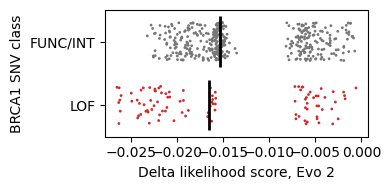

In [13]:
plt.figure(figsize=(4, 2))

# Plot stripplot of distributions
p = sns.stripplot(
    data=brca1_first_500_df,
    x='delta score',
    y='class',
    hue='class',
    order=['FUNC/INT', 'LOF'],
    palette=['#777777', 'C3'],
    size=2,
    jitter=0.3,
)

# Mark medians from each distribution
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'visible': False},
            medianprops={'color': 'k', 'ls': '-', 'lw': 2},
            whiskerprops={'visible': False},
            zorder=10,
            x="delta score",
            y="class",
            data=brca1_first_500_df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.xlabel('Delta likelihood score, Evo 2')
plt.ylabel('BRCA1 SNV class')
plt.tight_layout()
plt.show()

We can also calculate the area under the receiver operating characteristic curve (AUROC) of this zero-shot prediction method.

In [14]:
# Calculate AUROC of zero-shot predictions
y_true = (brca1_first_500_df['class'] == 'LOF')
auroc = roc_auc_score(y_true, -brca1_first_500_df['delta score'])

print(f'Zero-shot prediction AUROC: {auroc:.2}')

Zero-shot prediction AUROC: 0.62
